In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models

In [18]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
            directory = './dataset/PlantVillage',
            image_size = (IMG_SIZE, IMG_SIZE),
            batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
len(dataset)  # 68 as 2152 images have been divided into batches of 32

68

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for img_batch, label_batch in dataset.take(1):    # take(n) returns n batches
    print('SHAPE OF IMAGE BATCH:', img_batch.shape)
    print('SHAPE OF THE FIRST IMAGE:', img_batch[0].shape)
    print('LABELS OF THE IMAGE BATCH:', label_batch.numpy())
    print('LABEL OF THE FIRST IMAGE:', class_names[label_batch[0]])

SHAPE OF IMAGE BATCH: (32, 256, 256, 3)
SHAPE OF THE FIRST IMAGE: (256, 256, 3)
LABELS OF THE IMAGE BATCH: [1 1 0 1 1 0 0 1 2 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 2 1 0]
LABEL OF THE FIRST IMAGE: Potato___Late_blight


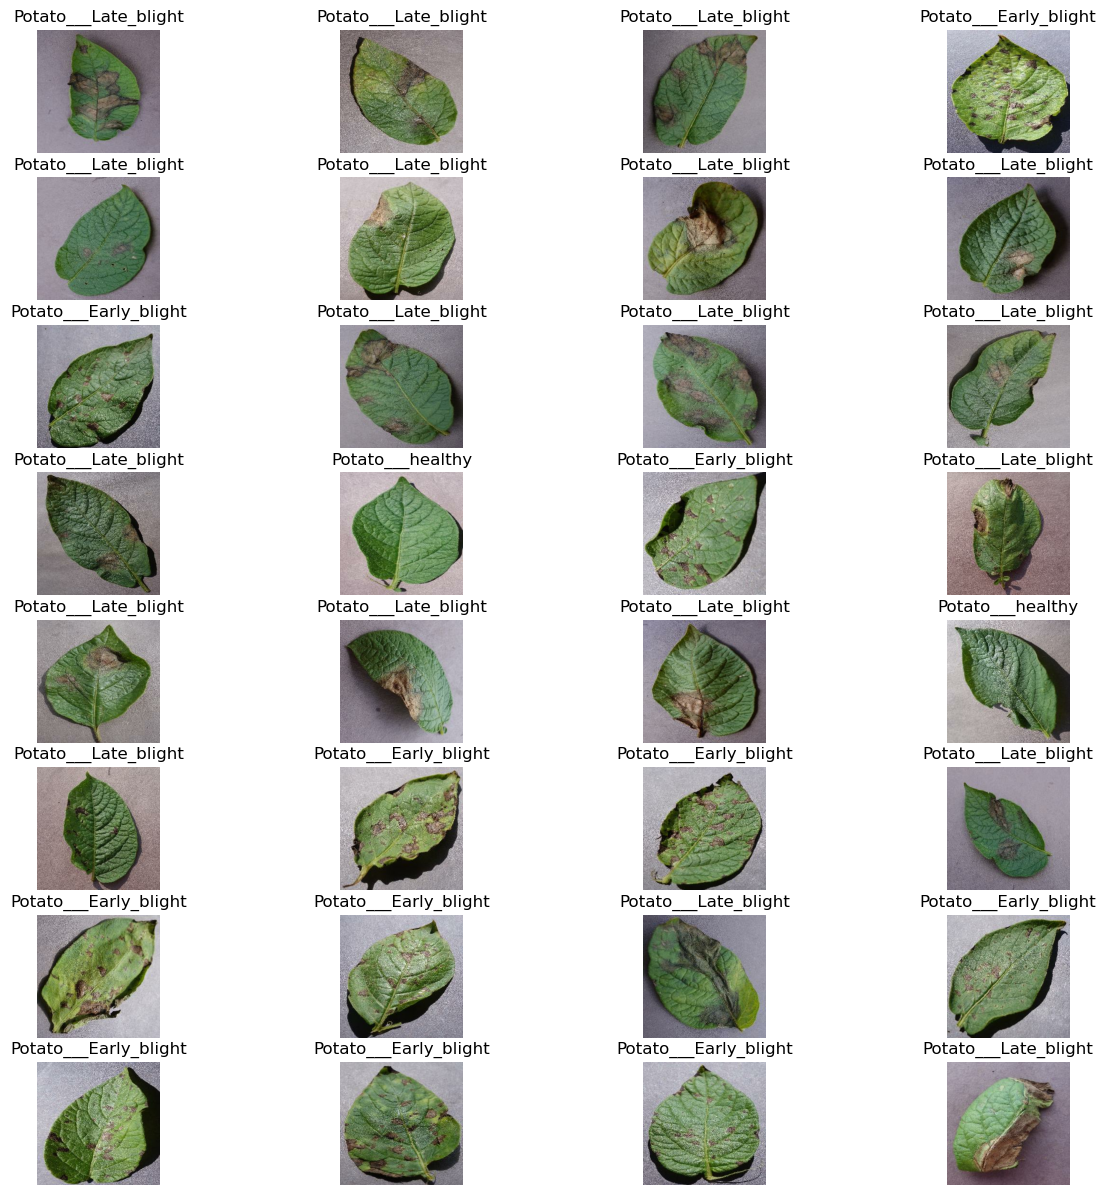

In [10]:
plt.figure(figsize=(15, 15))
for img_batch, label_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))         # Converting tensors to numpy array then to type integer
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [13]:
def train_val_dev_split(dataset, train_split=0.8, val_split=0.1, dev_split=0.1, shuffle=True, shuffle_size = 10000):
    if shuffle:
        dataset.shuffle(buffer_size = shuffle_size, seed=12)
        
    data_size = len(dataset)
    train_size = int(data_size*train_split)
    val_size = int(data_size*val_split)
    
    df_train = dataset.take(train_size)
    df_val = dataset.skip(train_size).take(val_size)
    df_dev = dataset.skip(train_size).skip(val_size)

    return df_train, df_val, df_dev    

In [16]:
df_train, df_val, df_dev = train_val_dev_split(dataset)
print(f'SIZE OF TRAIN, VALIDATION AND DEV DATASETS ARE {len(df_train)}, {len(df_val)} AND {len(df_dev)} RESPECTIVELY')

SIZE OF TRAIN, VALIDATION AND DEV DATASETS ARE 54, 6 AND 8 RESPECTIVELY


#### Check out https://www.tensorflow.org/api_docs/python/tf/data/Dataset methods for the next cell

In [17]:
train_df = df_train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = df_val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
dev_df = df_dev.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),    # Images will be resized to appropriate size before predicting
    tf.keras.layers.Rescaling(1./255.)
])

data_augmentor = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(factor=0.2)
])